In [1]:
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# File and Directory Paths
qa_pair_file = "qa_pairs.csv"

In [5]:
def check_row_length(file_path, row_length):
    """
    Checks if all rows in a csv file have the expected length.
    
    Args:
        file_path (str): The path to the csv file.
        row_length (int): The expected number of columns in each row.
        
    Returns:
        set: A set of corrupted rows that do not match the expected length.
    """
    corrupted_objects = set()
    
    with open(file_path, "r", encoding="utf-8") as metadata:
        spamreader = csv.reader(metadata, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in spamreader:
            if len(row) != row_length:
                corrupted_objects.add((row[0], row[1], row[2]))
                print(f"Unexpected row length of {len(row)} for: {row[0]}")
                
    print(f"Check for {file_path} complete. {len(corrupted_objects)} rows were corrupted.")
    return corrupted_objects

check_row_length(qa_pair_file, 4)

Check for qa_pairs.csv complete. 0 rows were corrupted.


set()

In [10]:
def check_question_ending(file_path, verbose=False):
    """
    Checks if the questions end with a question mark.
    
    Args:
        file_path (str): The path to the QA-pair csv file.
        verbose (bool, optional): Whether to print corrupted rows. Defaults to False.
    """
    corrupted_objects = set()
    
    with open(file_path, "r", encoding="utf-8") as metadata:
        spamreader = csv.reader(metadata, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in spamreader:
            if row[2][-1] != '?':  # Check if the question does not end with a question mark
                corrupted_objects.add((row[0], row[1]))
                if verbose:
                    print(f"Missing question mark for: {row[2]}")
    
    print(f"Check for {file_path} complete. {len(corrupted_objects)} rows were corrupted.")
                
check_question_ending(qa_pair_file, verbose=False)

Check for qa_pairs.csv complete. 60 rows were corrupted.


In [20]:
def count_labels(file_path):
    df = pd.read_csv(file_path, delimiter=";", quotechar="|")
    return df.iloc[:, 1].value_counts()

count_labels(qa_pair_file)

Figure    99732
Table     28184
Name: Figure, dtype: int64

In [38]:
def count_not_unique_questions(file_path):
    df = pd.read_csv(file_path, delimiter=";", quotechar="|")
    value_counts = df.iloc[:, 2].value_counts()
    return value_counts[value_counts >= 2]

not_unique_questions = count_not_unique_questions(qa_pair_file)
print(f"Number of not unique questions: {len(not_unique_questions)}")
print(f"Number of affected pairs: {not_unique_questions.sum()}")
print("\nExamples for not unique questions:")
print(not_unique_questions[0:10])

Number of not unique questions: 371
Number of affected pairs: 809

Examples for not unique questions:
According to Table                                                                                                    39
How should figures be included and referenced in a LaTeX document according to the provided text mentions?             7
How should figures be referenced in the text according to the provided instructions?                                   4
What is the order of convergence for $\|\eps_h\|$ when $h = 1/32$?                                                     4
How does the incorporation of annotations affect parameter estimation accuracy in the simulation study?                4
What is the empirical rejection rate for PSY when $\widetilde{r}=3$, $N=50$, and $T=200$ at a nominal rate of 5\%?     4
Which model achieves the highest F1 score according to Table \ref{tab:baseline}?                                       4
What is the convergence order of the AFC method whe

In [26]:
def get_qa_pair_statistics(file_path, object_type):
    """
    Analyzes the qa_pairs and prints statistics.
    
    Args:
        file_path (str): The path to the QA-pair csv file.
        object_type (str): The type of the object which shall be analyzed. Must be of {'Table', 'Figure', 'Overall'}.
        
    Raises:
        ValueError: If 'object_type' is not one of the expected values.
    """
    # Checking object_type
    if object_type not in ["Table", "Figure", "Table_02", "Overall"]:
        raise ValueError("Object_type must be of {'Table', 'Figure', 'Overall'}.")
    
    # Defining column indexes
    object_type_index = 1
    question_index = 2
    answer_index = 3
    
    # Defining bins for grouping
    bins_questions = [0, 5, 10, 15, 20, 25, 30, 35, 40, float('inf')]
    labels_questions = ["<=5", "6-10", "11-15", "16-20", "21-25", "26-30", "31-35", "36-40", ">40"]
    bins_answers = [0, 1, 2, 3, 4, 5, float('inf')]
    labels_answers = ["1", "2", "3", "4", "5", ">5"]
    bins_answers_02 = [0, 3, 6, 9, 12, 15, 18, 21, float('inf')]
    labels_answers_02 = ["<=3", "4-6", "7-9", "10-12", "13-15", "16-18", "19-21", ">21"]
    
    # Loading and filtering
    df = pd.read_csv(file_path, delimiter=";", quotechar="|")
    if object_type != "Overall":
        df = df[df.iloc[:, object_type_index] == object_type]
    
    # Getting word counts
    word_counts_question = df.iloc[:, question_index].astype(str).apply(lambda x: len(x.split()))
    word_counts_answer = df.iloc[:, answer_index].astype(str).apply(lambda x: len(x.split()))
    
    # Getting min, mean, median and max word lenghts
    min_question_length = word_counts_question.min()
    min_answer_length = word_counts_answer.min()
    average_question_length = word_counts_question.mean()
    average_answer_length = word_counts_answer.mean()
    median_question_length = word_counts_question.median()
    median_answer_length = word_counts_answer.median()
    max_question_length = word_counts_question.max()
    max_answer_length = word_counts_answer.max()
    
    # Getting word distribtuions for questions
    word_count_distribution_question = pd.cut(word_counts_question, bins=bins_questions, labels=labels_questions, right=True)
    distribution_counts_question = word_count_distribution_question.value_counts().sort_index()
    distribution_counts_question.name = "Question word count"
    
    # Getting word distribtuions for answers (small range)
    word_count_distribution_answer = pd.cut(word_counts_answer, bins=bins_answers, labels=labels_answers, right=True)
    distribution_counts_answer = word_count_distribution_answer.value_counts().sort_index()
    distribution_counts_answer.name = "Answer word count"
    
    # Getting word distribtuions for answers (big range)
    word_count_distribution_answer_02 = pd.cut(word_counts_answer, bins=bins_answers_02, labels=labels_answers_02, right=True)
    distribution_counts_answer_02 = word_count_distribution_answer_02.value_counts().sort_index()
    distribution_counts_answer_02.name = "Answer word count"
    
    # Print average and max values
    print(f"{object_type} results:\n")
    print(f"Min question length: {min_question_length} words")
    print(f"Median question length: {median_question_length} words")
    print(f"Average question length: {round(average_question_length, 2)} words")
    print(f"Max question length: {max_question_length} words\n")
    print(f"Min answer length: {min_answer_length} words")
    print(f"Median answer length: {median_answer_length} words")
    print(f"Average answer length: {round(average_answer_length, 2)} words")
    print(f"Max answer length: {max_answer_length} words\n")
    
    # Print word count distributions
    print("Word count distribution for questions:")
    print(distribution_counts_question)
    print("\nWord count distributions for answers (small range):")
    print(distribution_counts_answer)
    print("\nWord count distributions for answers (big range):")
    print(distribution_counts_answer_02)
    
    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    distribution_counts_question.plot(kind="bar",
                                      ax=axes[0][0],
                                      title="Question Word Count Distribution",
                                      ylabel="Number of Questions",
                                      xlabel="Word Count Range")
    distribution_counts_answer.plot(kind="bar",
                                    ax=axes[0][1],
                                    title="Answer Word Count Distribution",
                                    ylabel="Number of Answers",
                                    xlabel="Word Count Range",
                                    color="forestgreen")
    distribution_counts_answer_02.plot(kind="bar",
                                    ax=axes[1][1],
                                    title="Answer Word Count Distribution",
                                    ylabel="Number of Answers",
                                    xlabel="Word Count Range",
                                    color="forestgreen")
    plt.tight_layout()
    plt.show()

Overall results:

Min question length: 3 words
Median question length: 19.0 words
Average question length: 19.18 words
Max question length: 53 words

Min answer length: 1 words
Median answer length: 8.0 words
Average answer length: 8.69 words
Max answer length: 145 words

Word count distribution for questions:
<=5         47
6-10      1824
11-15    24795
16-20    55827
21-25    34266
26-30     9430
31-35     1538
36-40      161
>40         28
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1     23513
2      7924
3      6625
4      5565
5      6441
>5    77848
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      38062
4-6      18661
7-9      20846
10-12    17706
13-15    12553
16-18     8063
19-21     5047
>21       6978
Name: Answer word count, dtype: int64


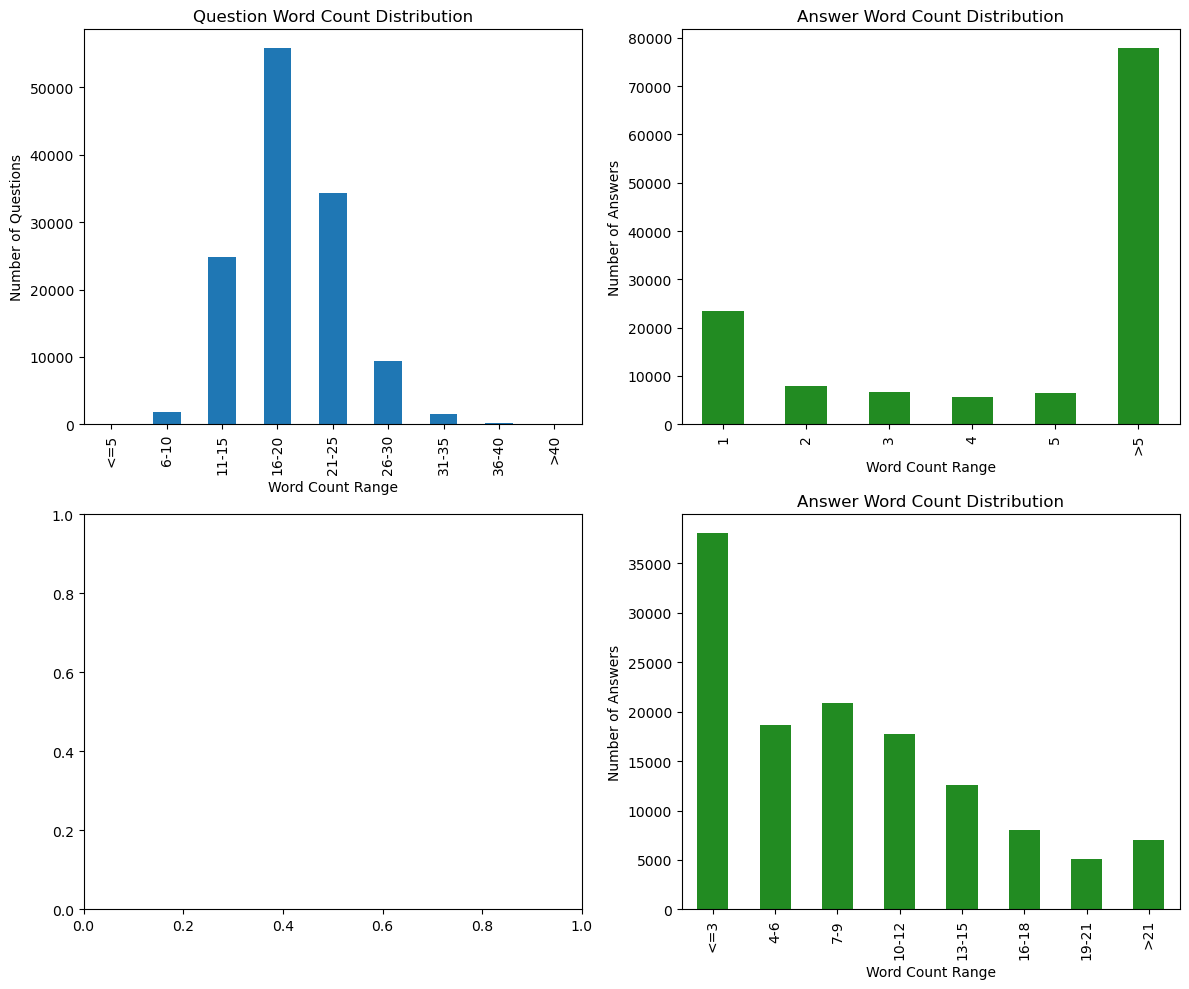

In [27]:
get_qa_pair_statistics(qa_pair_file, "Overall")

Figure results:

Min question length: 3 words
Median question length: 19.0 words
Average question length: 19.77 words
Max question length: 53 words

Min answer length: 1 words
Median answer length: 10.0 words
Average answer length: 10.65 words
Max answer length: 98 words

Word count distribution for questions:
<=5          6
6-10       625
11-15    14684
16-20    44768
21-25    29795
26-30     8342
31-35     1354
36-40      137
>40         21
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1      3457
2      3947
3      4658
4      4850
5      5936
>5    76884
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      12062
4-6      17195
7-9      20470
10-12    17551
13-15    12480
16-18     8019
19-21     5024
>21       6931
Name: Answer word count, dtype: int64


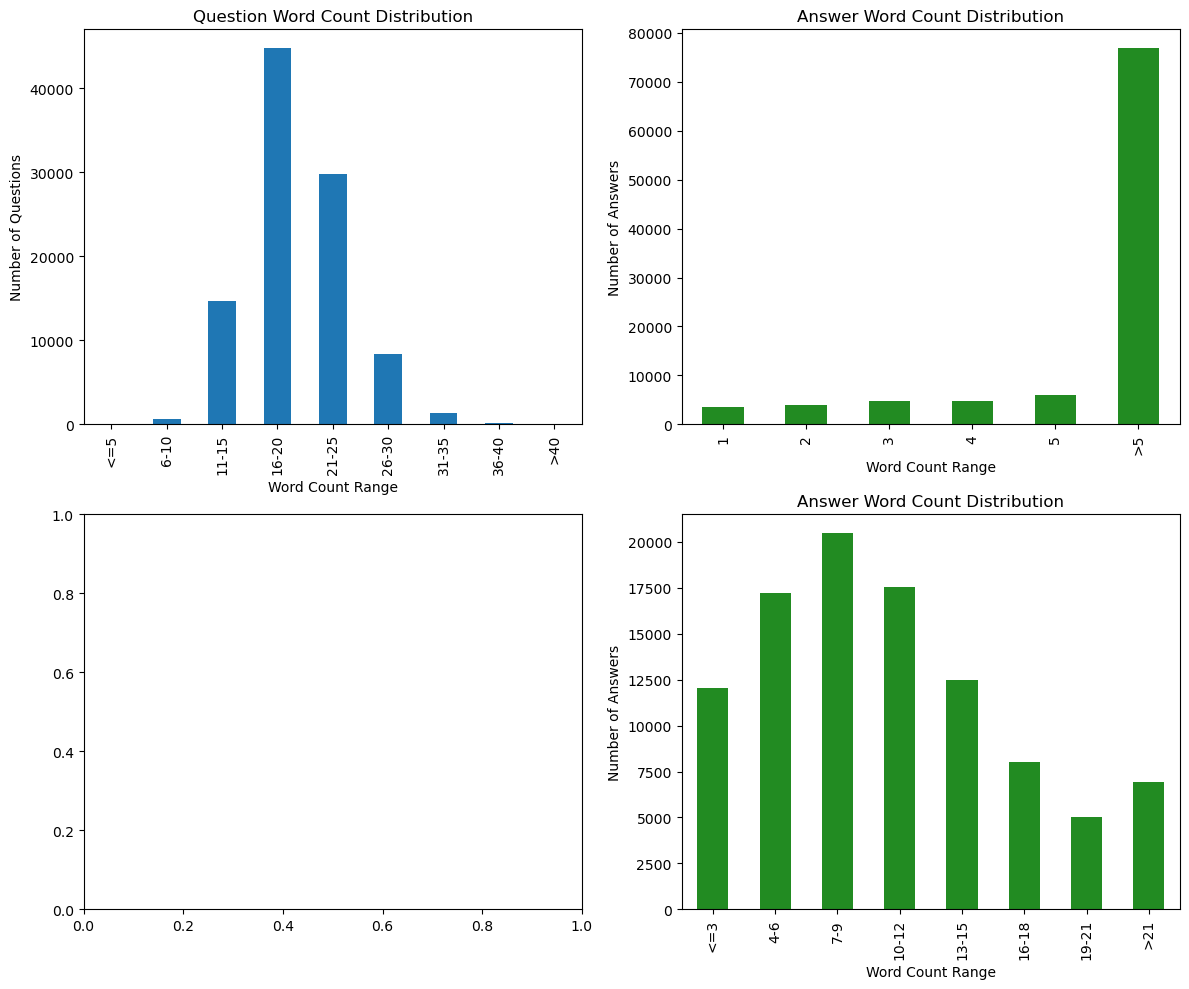

In [28]:
get_qa_pair_statistics(qa_pair_file, "Figure")

Table results:

Min question length: 3 words
Median question length: 17.0 words
Average question length: 17.07 words
Max question length: 47 words

Min answer length: 1 words
Median answer length: 1.0 words
Average answer length: 1.74 words
Max answer length: 145 words

Word count distribution for questions:
<=5         41
6-10      1199
11-15    10111
16-20    11059
21-25     4471
26-30     1088
31-35      184
36-40       24
>40          7
Name: Question word count, dtype: int64

Word count distributions for answers (small range):
1     20056
2      3977
3      1967
4       715
5       505
>5      964
Name: Answer word count, dtype: int64

Word count distributions for answers (big range):
<=3      26000
4-6       1466
7-9        376
10-12      155
13-15       73
16-18       44
19-21       23
>21         47
Name: Answer word count, dtype: int64


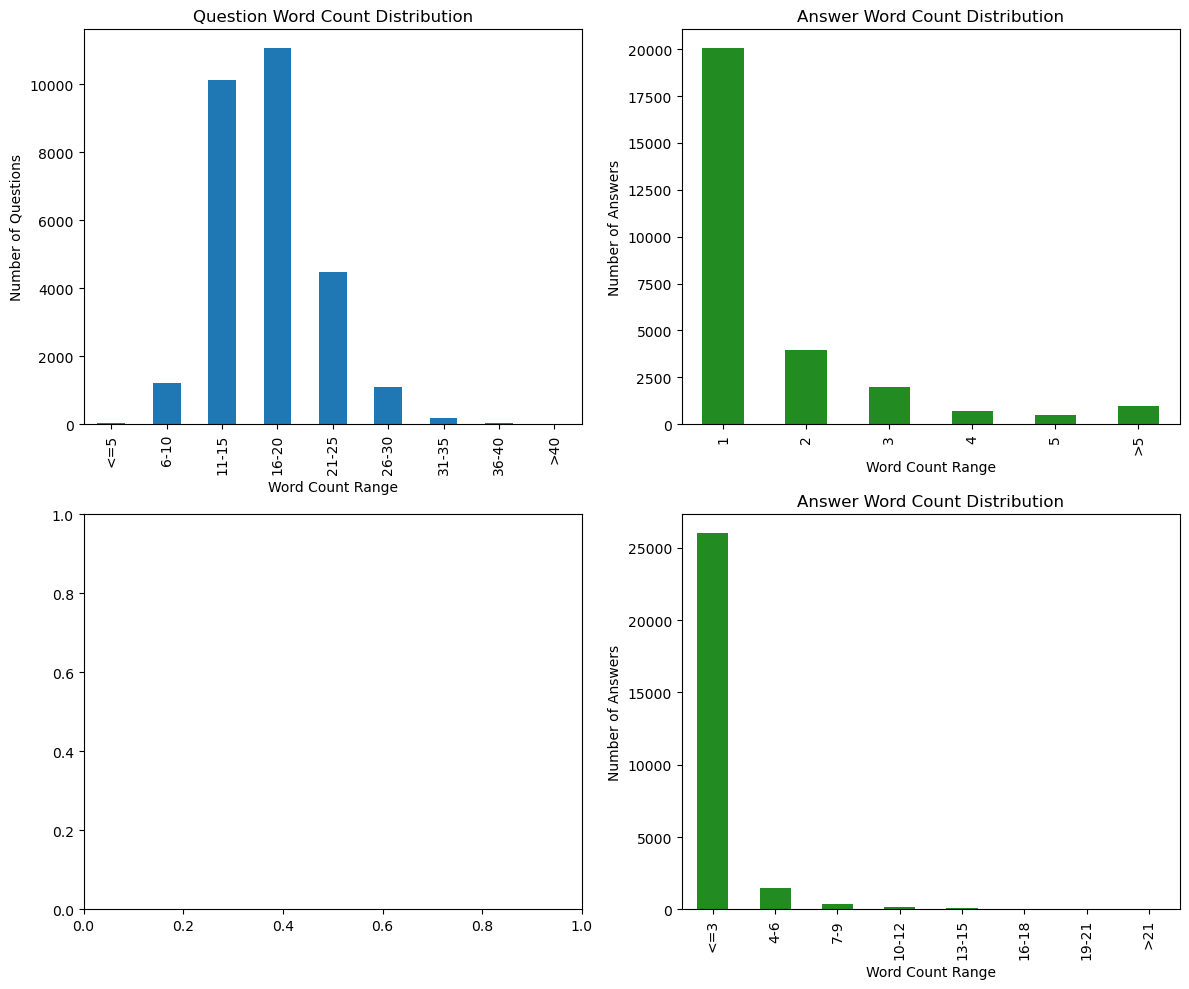

In [29]:
get_qa_pair_statistics(qa_pair_file, "Table")